| Column | Description |
| -- | -- |
| _id |	Unique row identifier for Open Data database |
| APPLICATION# | Development application file number. Example: 19 123456 STE 01 OZ |
| APPLICATION_TYPE | Type of application. |
| DATE_SUBMITTED | Date that the application was accepted by the City. Example: 06/29/2018 (mm/dd/yyyy) |
| DESCRIPTION | Brief description of the application |
| HEARING_DATE | Hearing date of the Committee of Adjustment application. Example: 01/05/2019 (mm/dd/yyyy) | 
| POSTAL | First 3 digits of postal code. Example: M5V |
| REFERENCE_FILE# | Committee of Adjustment or Toronto Local Appeal Body specific reference file number. |
| STATUS | Current status of the application. Example: Under Review |
| STREET_DIRECTION | Address – street direction. Example: E |
| STREET_NAME | Address – street name. Example: Bloor |
| STREET_NUM | Address – street number. Example: 1 |
| STREET_TYPE | Address – street type. Example: Street |
| X	| X coordinates. Example: 314085.95 |
| Y | Y coordinates. Example: 4387731.64 |
| APPLICATION_NUMBER | |
| REFERENCE_FILE_NUMBER	| | 

Application types:
- CD - Condominium
- OZ - Official Plan/Rezoning
- PL - Part Lot
- SA - Site Plan Application
- SB - Sub Division
- CO - Consent
- MV - Minor Variance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import requests
from bs4 import BeautifulSoup

# TODO
- group data by date and postal code (done)
- join data based on date and postal code (done)
- get a neighbourhood name to represent each postal code (done)
- flatten data in perms to include all cost in 'Total Affected Area' and 'Affected Area Type'
- if there is time...
    - extract keywords for descriptions
    - fill in missing postal codes
    - refactor and put on git

### Notes
- some dates are missing
- most of the construction cost info does not appear to be filled out...
- some postal code fields are empty...


### read in data

In [83]:
# development applications
apps_df_raw = pd.read_csv('./data/development-applications/Development Applications Data.csv')

# building permits
perms_path = './data/building-permits/'
all_files = glob.glob(perms_path+"/*.csv")

df_list = []

for file_name in all_files:
    df = pd.read_csv(file_name, index_col=None, header=0)
    df['year_from_file_name'] = file_name[-8:-4]
    df_list.append(df)

perms_df_raw = pd.concat(df_list, axis=0, ignore_index=True)

perms_df_raw.to_csv('./data/combined/perms_raw.csv')

In [230]:
apps_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67068 entries, 0 to 67067
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _id                    67068 non-null  int64  
 1   APPLICATION#           0 non-null      float64
 2   APPLICATION_TYPE       67068 non-null  object 
 3   DATE_SUBMITTED         67068 non-null  object 
 4   DESCRIPTION            65440 non-null  object 
 5   HEARING_DATE           46632 non-null  object 
 6   POSTAL                 67068 non-null  object 
 7   REFERENCE_FILE#        0 non-null      float64
 8   STATUS                 67068 non-null  object 
 9   STREET_DIRECTION       67068 non-null  object 
 10  STREET_NAME            67051 non-null  object 
 11  STREET_NUM             67051 non-null  object 
 12  STREET_TYPE            67068 non-null  object 
 13  X                      65940 non-null  float64
 14  Y                      65940 non-null  float64
 15  AP

In [231]:
perms_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311132 entries, 0 to 311131
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERMIT_NUM                      311132 non-null  object 
 1   REVISION_NUM                    311132 non-null  object 
 2   PERMIT_TYPE                     311132 non-null  object 
 3   STRUCTURE_TYPE                  309878 non-null  object 
 4   WORK                            310982 non-null  object 
 5   STREET_NUM                      311131 non-null  object 
 6   STREET_NAME                     311131 non-null  object 
 7   STREET_TYPE                     311132 non-null  object 
 8   STREET_DIRECTION                311132 non-null  object 
 9   POSTAL                          311132 non-null  object 
 10  GEO_ID                          305299 non-null  float64
 11  WARD_GRID                       311131 non-null  object 
 12  APPLICATION_DATE

### clean up data

In [84]:
# copy original data to compare later
apps_df = apps_df_raw.copy()
perms_df = perms_df_raw.copy()

In [81]:
# change date cols to datetime
apps_df['DATE_SUBMITTED'] = pd.to_datetime(apps_df['DATE_SUBMITTED'])
perms_df['APPLICATION_DATE'] = pd.to_datetime(perms_df['APPLICATION_DATE'])

In [234]:
# drop any dates that are missing / incorrect
#perms_df = perms_df[perms_df['APPLICATION_DATE'] >= pd.to_datetime('01-01-2012')]
apps_df = apps_df[apps_df['DATE_SUBMITTED'] >= pd.to_datetime('01-01-2012')]

In [235]:
perms_df.shape[0] / perms_df_raw.shape[0]

1.0

In [236]:
apps_df.shape[0] / apps_df_raw.shape[0]

0.7349555674837478

In [237]:
# create month and year columns for grouping
apps_df['Month'] = apps_df['DATE_SUBMITTED'].dt.month
apps_df['Year'] = apps_df['DATE_SUBMITTED'].dt.year

In [238]:
# create columns of 1s for counting
perms_df['Building Permit Count'] = 1
apps_df['Development Application Count'] = 1

### create mapping of postal codes to neighbourhood names

In [251]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

website_content = requests.get(wiki_url).text
soup = BeautifulSoup(website_content, 'lxml')
table = soup.find('table', {'class':'wikitable sortable'})
postal_mapping = pd.DataFrame()

for row in table.find_all('tr'):
    row_dict = {}
    data = row.find_all('td')
    if len(data) > 0:
        row_dict['POSTAL'] = data[0].text.strip()
        row_dict['Borough'] = data[1].text.strip()
        row_dict['Neighbourhood'] = data[2].text.strip()
        postal_mapping = postal_mapping.append(row_dict, ignore_index=True)

postal_mapping.to_csv('./data/combined/postal_code_mapping.csv', header=True, index=False)

### group data by year, month, postal code

In [243]:
grouped_perms = perms_df.groupby(['year_from_file_name', 'POSTAL', 'PERMIT_TYPE']).agg('sum').reset_index()
grouped_apps = apps_df.groupby(['Year', 'POSTAL', 'APPLICATION_TYPE']).agg('sum')


In [ ]:
# write out to file
grouped_perms.to_csv('./data/combined/grouped_permits.csv')
grouped_apps.to_csv('./data/combined/grouped_applications.csv')

### join data on year, month, postal code

In [53]:
joined_df = grouped_perms.join(grouped_apps, ['Year', 'Month', 'POSTAL'])

In [54]:
joined_df.reset_index(inplace=True)

### write out result to file

In [55]:
joined_df.to_csv('./data/combined/combined.csv')

In [92]:
apps_df['POSTAL'] = apps_df['POSTAL'].apply(lambda x: x.strip())

In [100]:
apps_df['POSTAL'] = apps_df['POSTAL'].apply(lambda x: x if len(x) == 3 else None)

In [107]:
apps_df[apps_df['POSTAL'].isnull()]['STREET_NAME']

25       FOREST MANOR
71          ST GEORGE
73              HURON
98              BLOOR
268      GORDON BAKER
             ...     
66999       ST MAGNUS
67041       ST MAGNUS
67043       ST MAGNUS
67051           MCNAB
67052           MCNAB
Name: STREET_NAME, Length: 3895, dtype: object

In [3]:
def summarize_categorical(data, column_name):
    meta_data = {'column_name': column_name,
                'data_type': 'category',
                'sample size': len(data[column_name]),
                'number of unique values':data[column_name].nunique(),
                'proportion of values populated': data[column_name].count() / len(data[column_name])}

    return meta_data

In [205]:
summarize_categorical(apps_df, 'APPLICATION_TYPE')

{'column_name': 'APPLICATION_TYPE',
 'data_type': 'category',
 'sample size': 49292,
 'number of unique values': 8,
 'proportion of values populated': 1.0}

In [4]:
def plot_categorical(data, column_name, save=False, top_n=20):

    # count the number of occurences of each categorical value
    counts = data[column_name].value_counts().sort_values(ascending=False)[0:top_n]

    # plot as bar graph
    fig, ax = plt.subplots(figsize=(15,9))
    rects = ax.bar(counts.index, counts.values)
    ax.tick_params(labelrotation=20, axis='x')

    # annotate bar graph with numbers
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height+5,
                '%d' % int(height),
                ha='center', va='bottom')

    # add title
    ax.set_title(f'Countplot of {column_name}')

    # add metadata
    metadata = summarize_categorical(data, column_name)
    plt.figtext(0.5, 0.01, "Metadata\n" + str(metadata), ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    # save for later if required
    if save: fig.savefig(f'./plots/{column_name}.png')

    return None

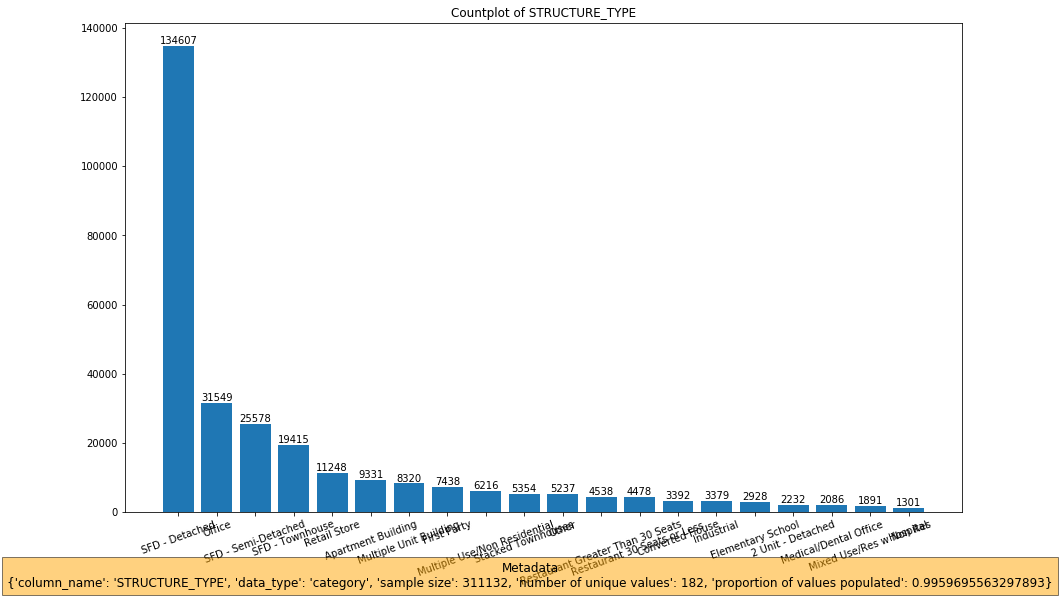

In [207]:
plot_categorical(perms_df, 'STRUCTURE_TYPE')

In [142]:
def create_category(description):
    desc = str(description)

    keyword_map = {'residential':['residential', 'dwelling', 'apartment', 'house', 'condo', 'porch', 'townhouse', 'deck', 'basement', 'pool', 'condomimium'],
                'commercial':['commercial', 'restaurant', 'office', 'institutional', 'warehouse', 'corporations'],
                'parking':['parking', 'garage', 'driveway']}

    #remove punctuation
    split_desc = desc.split(' ')
    for i in range(len(split_desc)):
        split_desc[i] = re.sub(r'[^\w\s]','',split_desc[i].lower())

    if any(tag in split_desc for tag in keyword_map['residential']): return 'residential'
    elif any(tag in split_desc for tag in keyword_map['commercial']): return 'commercial'
    elif any(tag in split_desc for tag in keyword_map['parking']): return 'parking'
    else: return 'None'

In [143]:
apps_df['category'] = apps_df['DESCRIPTION'].apply(lambda x: create_category(x))

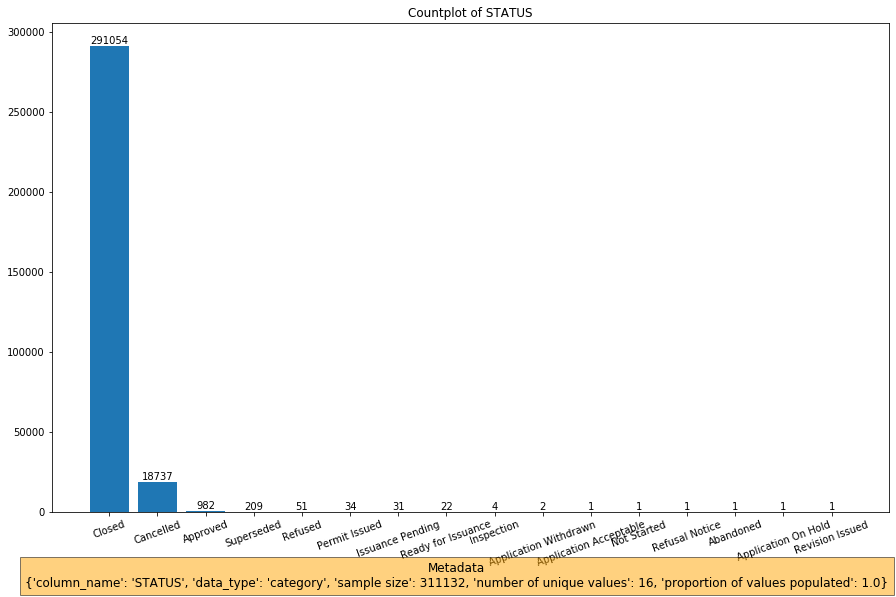

In [209]:
plot_categorical(perms_df, 'STATUS')

In [145]:
for row in apps_df[apps_df['category'] == 'None']['DESCRIPTION'][0:100]:
    print(row)

To maintain the existing holistic wellness and aroma therapy massage centre.  Previous Committee of Adjustment decisions (File Numbers A356/91, A236/98ET & A600/15EYK) approved minor variances related to use of the unit as a non-therapeutic massage and health centre.
To alter the existing three-storey townhouse/rowhouse by constructing a flat roof third floor addition and a secondary suite.
nan
To construct a drive-through in the south portion of the plaza for the existing Tim Hortons.
To construct a one-storey front addition.
To construct a raised platform.
Proposal to sever the land at 103 Westbourne Avenue into two lots for single family houses.
To convert a portion of the existing building into a vehicle dealership. 
To permit a vehicle rental establishment. A previous Committee of Adjustment application (A-285/76) approved variances related to restricting the use to the sale of new and used vehicles and for minor servicing of the said vehicles.
To construct a new a new four-storey

# Building permits data

In [5]:
perms_path = './data/building-permits/'
all_files = glob.glob(perms_path+"/*.csv")

df_list = []

for file_name in all_files:
    df = pd.read_csv(file_name, index_col=None, header=0)
    df_list.append(df)

perms_df = pd.concat(df_list, axis=0, ignore_index=True)

In [7]:
perms_df.columns

Index(['PERMIT_NUM', 'REVISION_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK',
       'STREET_NUM', 'STREET_NAME', 'STREET_TYPE', 'STREET_DIRECTION',
       'POSTAL', 'GEO_ID', 'WARD_GRID', 'APPLICATION_DATE', 'ISSUED_DATE',
       'COMPLETED_DATE', 'STATUS', 'DESCRIPTION', 'CURRENT_USE',
       'PROPOSED_USE', 'DWELLING_UNITS_CREATED', 'DWELLING_UNITS_LOST',
       'EST_CONST_COST', 'ASSEMBLY', 'INSTITUTIONAL', 'RESIDENTIAL',
       'BUSINESS_AND_PERSONAL_SERVICES', 'MERCANTILE', 'INDUSTRIAL',
       'INTERIOR_ALTERATIONS', 'DEMOLITION'],
      dtype='object')

In [11]:
summarize_categorical(perms_df, 'PERMIT_TYPE')

{'column_name': 'PERMIT_TYPE',
 'data_type': 'category',
 'sample size': 168746,
 'number of unique values': 19,
 'proportion of values populated': 1.0}

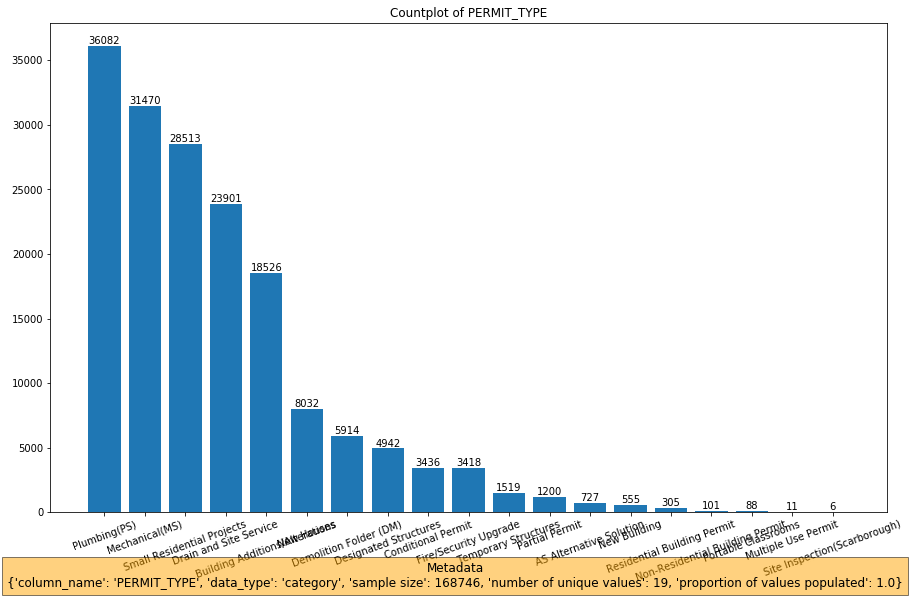

In [12]:
plot_categorical(perms_df, 'PERMIT_TYPE')

In [13]:
summarize_categorical(perms_df, 'WORK')


{'column_name': 'WORK',
 'data_type': 'category',
 'sample size': 168746,
 'number of unique values': 109,
 'proportion of values populated': 0.9998222180081305}

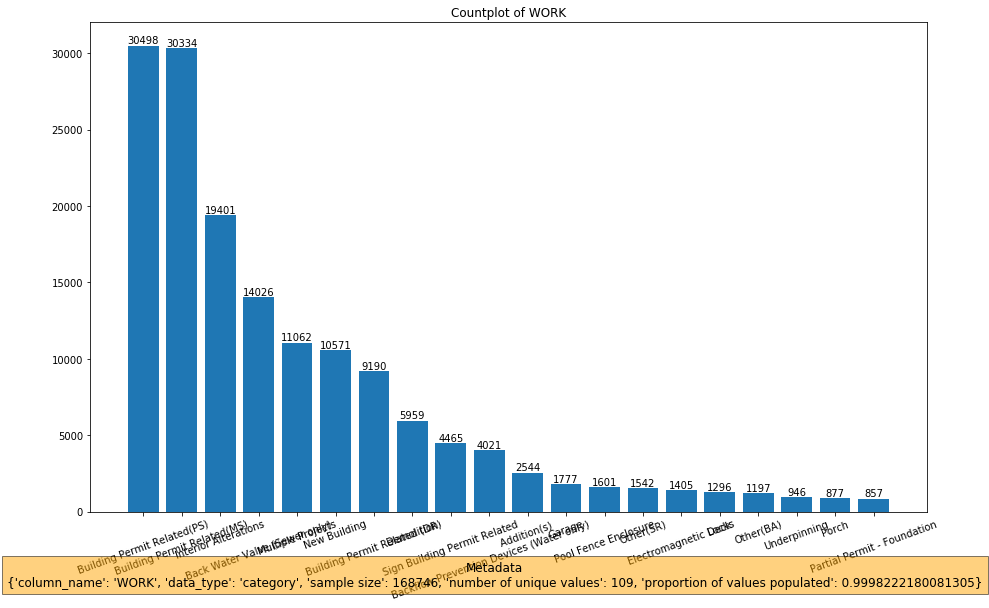

In [15]:
plot_categorical(perms_df, 'WORK')

In [38]:
summarize_categorical(perms_df, 'STRUCTURE_TYPE')

{'column_name': 'STRUCTURE_TYPE',
 'data_type': 'category',
 'sample size': 163331,
 'number of unique values': 156,
 'proportion of values populated': 0.995555038541367}

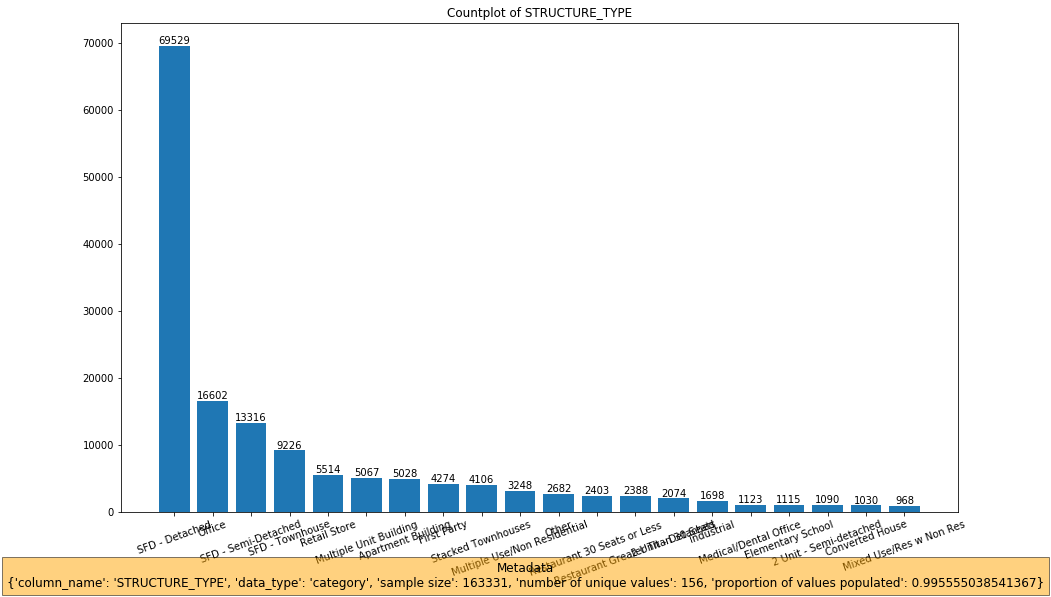

In [39]:
plot_categorical(perms_df, 'STRUCTURE_TYPE')

In [16]:
perms_df.describe()

,GEO_ID,DWELLING_UNITS_CREATED,DWELLING_UNITS_LOST,ASSEMBLY,INSTITUTIONAL,RESIDENTIAL,BUSINESS_AND_PERSONAL_SERVICES,MERCANTILE,INDUSTRIAL,INTERIOR_ALTERATIONS,DEMOLITION
count,1.659860e+05,54716.000000,54567.000000,168746.000000,168746.000000,168746.000000,168746.000000,168746.000000,168746.000000,168746.000000,168746.000000
mean,6.073201e+06,0.639228,0.088772,1.494288,0.187879,26.304413,3.398942,1.427992,8.031611,37.563723,14.485180
std,6.871217e+06,13.730017,0.543831,87.791142,53.538300,676.192471,465.755572,112.338120,427.362374,360.998857,376.806969
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.617490e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.815070e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.213006e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.011506e+07,985.000000,44.000000,13150.000000,21451.000000,94072.000000,107833.400000,22611.000000,110224.800000,40113.000000,89506.850000


In [17]:
perms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168746 entries, 0 to 168745
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PERMIT_NUM                      168746 non-null  object 
 1   REVISION_NUM                    168746 non-null  object 
 2   PERMIT_TYPE                     168746 non-null  object 
 3   STRUCTURE_TYPE                  167993 non-null  object 
 4   WORK                            168716 non-null  object 
 5   STREET_NUM                      168745 non-null  object 
 6   STREET_NAME                     168745 non-null  object 
 7   STREET_TYPE                     168746 non-null  object 
 8   STREET_DIRECTION                168746 non-null  object 
 9   POSTAL                          168746 non-null  object 
 10  GEO_ID                          165986 non-null  float64
 11  WARD_GRID                       168745 non-null  object 
 12  APPLICATION_DATE

In [34]:
perms_df['COMPLETED_DATE'] = pd.to_datetime(perms_df['COMPLETED_DATE']).dt.date
perms_df['APPLICATION_DATE'] = pd.to_datetime(perms_df['APPLICATION_DATE']).dt.date
perms_df['ISSUED_DATE'] = pd.to_datetime(perms_df['ISSUED_DATE']).dt.date

In [12]:
perms_df[perms_df['COMPLETED_DATE'] < pd.to_datetime('01-01-2016')]

TypeError: '<' not supported between instances of 'str' and 'Timestamp'

## 5k rows are missing dates.. Lets just drop them and not worry about it for now.

In [30]:
perms_df = perms_df[perms_df['COMPLETED_DATE'] >= pd.to_datetime('01-01-2016')]

In [31]:
perms_df.shape

(163331, 30)

## Lets group them by date and see what it looks like

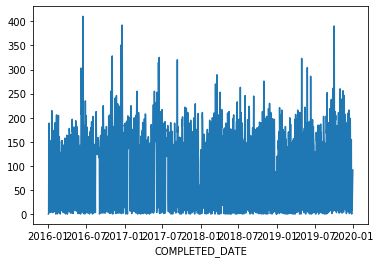

In [37]:
perms_df.groupby('COMPLETED_DATE').agg('count')['PERMIT_TYPE'].plot()

# Business licences data

In [2]:
bus_df = pd.read_csv('./data/business-permits/business.licences.csv')
bus_df

/Users/dhrun/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Category,Licence No.,Operating Name,Issued,Client Name,Business Phone,Business Phone Ext.,Licence Address Line 1,Licence Address Line 2,Licence Address Line 3,Conditions,Free Form Conditions Line 1,Free Form Conditions Line 2,Plate No.,Endorsements,Cancel Date
0,PRIVATE TRANSPORTATION COMPANY,B02-4741962,TAXIFY,18-JAN-2018,TAXIFY CANADA INC,NaN,NaN,"35 OAK ST, #304","TORONTO, ON",M9N 1A1,TAXIFY;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,07-DEC-2018
1,PRIVATE TRANSPORTATION COMPANY,B02-4728645,INSTARYDE,08-SEP-2017,INSTARYDE INC,NaN,NaN,425 ALNESS ST,"TORONTO, ON",M3J 2T8,INSTARYDE;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,10-DEC-2018
2,PRIVATE TRANSPORTATION COMPANY,B02-4653451,UBER CANADA,16-AUG-2016,UBER CANADA INC,5.145898e+09,NaN,"121 BLOOR ST E, #1600","TORONTO, ON",M4W 3M5,MAILING ADDRESS ONLY; MUST COMPLY WITH CITY/ZO...,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,NaN
3,PRIVATE TRANSPORTATION COMPANY,B02-4691773,FACEDRIVE,04-APR-2017,FACEDRIVE INC,NaN,NaN,"44 EAST BEAVER CREEK RD, #16","RICHMOND HILL, ON",L4B 1G8,FACEDRIVE;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,NaN
4,PRIVATE TRANSPORTATION COMPANY,B02-4714142,RIDEIN,18-MAY-2017,RIDE INC,4.162314e+09,NaN,379 BERING AVE,"TORONTO, ON",M8Z 3B1,RIDEIN;,NaN,NaN,NaN,PRIVATE TRANSPORTATION COMPANY;,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155381,NON-MOTORIZED REFRESHMENT VEHICLE OWNER,V27-5025566,BORN2EAT CANADA,27-JUL-2020,BORN2EAT CANADA LTD,NaN,NaN,5A DORVAL RD,"TORONTO, ON",M6P 2B2,MUST COMPLY WITH ALL CITY AND ZONING BY-LAWS;S...,"ICE CREAM ROLL, DUMPLING, BAO, TACOS",NaN,01994,RV - NON-MOTOR. (NOT PROPANE/ICE CREAM);,NaN
155382,NON-MOTORIZED REFRESHMENT VEHICLE OWNER,V27-5024999,NaN,27-JUL-2020,"ATANASSOV, TZVETANKA G",NaN,NaN,NaN,NaN,L4J,MUST COMPLY WITH ALL CITY AND ZONING BY-LAWS;C...,NaN,NaN,01996,RV - NON-MOTORIZED - PROPANE HEATER;,NaN
155383,NON-MOTORIZED REFRESHMENT VEHICLE OWNER,V27-5036387,THE CUBAN THING,06-OCT-2020,2766911 ONTARIO LTD,NaN,NaN,"2493 LAKE SHORE BLVD W, #310","TORONTO, ON",M8V 1C7,MUST COMPLY WITH ALL CITY AND ZONING BY-LAWS;C...,NaN,NaN,01813,RV - NON-MOTORIZED - PROPANE HEATER;,NaN
155384,NON-MOTORIZED REFRESHMENT VEHICLE OWNER,V27-5038743,SPN HOT DOG,03-NOV-2020,SPN SUPER CLEANERS INC,NaN,NaN,2025 KIPLING AVE,"TORONTO, ON",M9W 4J8,MUST COMPLY WITH ALL CITY AND ZONING BY-LAWS;C...,NaN,NaN,01809,RV - TRAILER - ELECTRIC;,NaN


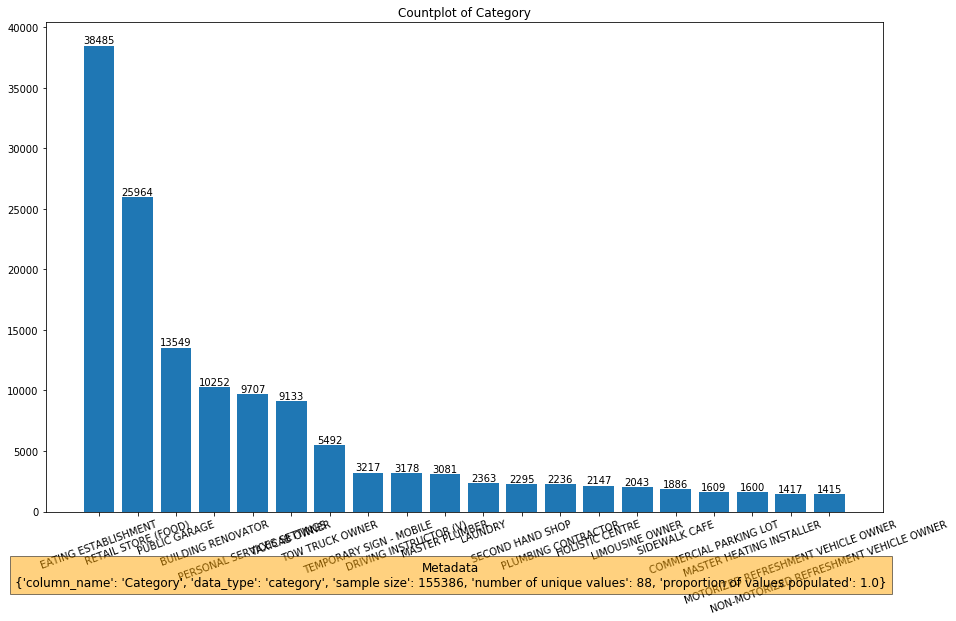

In [5]:
plot_categorical(bus_df, 'Category')

In [7]:
bus_df['Licence Address Line 3'][0][:3]

'M9N'

In [9]:
bus_df['FSA'] = bus_df['Licence Address Line 3'].apply(lambda x: str(x)[:3])

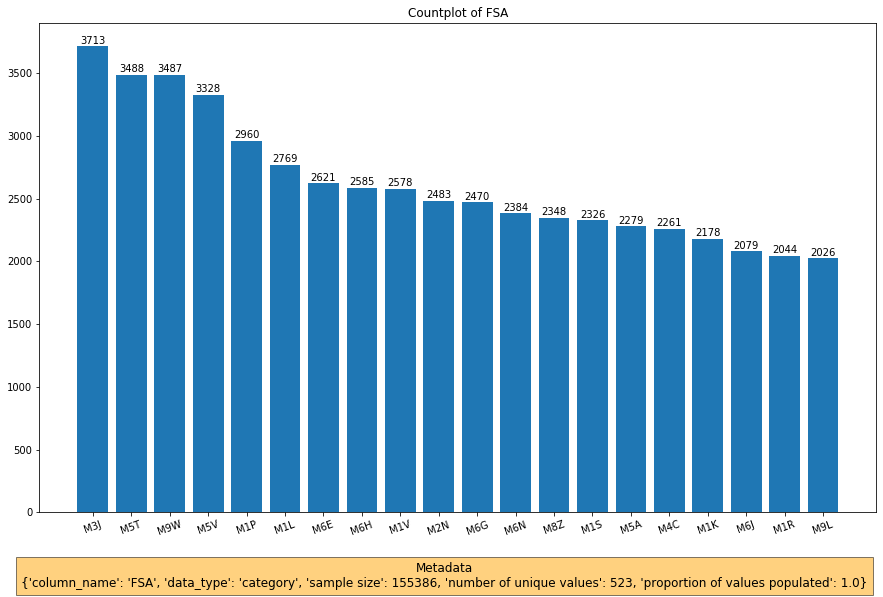

In [10]:
plot_categorical(bus_df, 'FSA')

In [24]:
bus_df['FSA'].value_counts() > 500

M3J     True
M5T     True
M9W     True
M5V     True
M1P     True
       ...  
M5Z    False
V6A    False
G1V    False
P0R    False
L0O    False
Name: FSA, Length: 523, dtype: bool

# 2020-2021 data only

In [147]:
recent_apps_df = apps_df[apps_df['DATE_SUBMITTED'] >= pd.to_datetime('2020-01-01')]

TypeError: '>=' not supported between instances of 'str' and 'Timestamp'

In [97]:
recent_years = ['2019','2020', '2021']

perms_df['app_date_year'] = perms_df['APPLICATION_DATE'].apply(lambda x: str(x)[:4])

recent_perms_df = perms_df[perms_df['app_date_year'].isin(recent_years)]

recent_perms_df.reset_index(inplace=True)

In [139]:
def fix_date(bad_date):
    
    if len(str(bad_date)) > 10:
        result = pd.to_datetime(str(bad_date)[:8])
    else:
        result = pd.to_datetime(str(bad_date))
        
    return result
        

In [140]:
fix_date(str(recent_perms_df['APPLICATION_DATE'][0]))

Timestamp('2019-01-28 00:00:00')

In [141]:
recent_perms_df['APPLICATION_DATE_CUSTOM'] = recent_perms_df['APPLICATION_DATE'].apply(lambda x: fix_date(x))

/Users/dhrun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
sum(recent_perms_df['APPLICATION_DATE_CUSTOM'] < pd.to_datetime('2019-01-01'))

0

In [146]:
recent_perms_df['APPLICATION_DATE_CUSTOM'].value_counts()

2019-03-19    265
2019-03-07    212
2019-06-19    169
2019-04-11    167
2019-02-25    166
             ... 
2020-11-22      1
2020-03-15      1
2020-04-05      1
2020-11-01      1
2020-02-29      1
Name: APPLICATION_DATE_CUSTOM, Length: 602, dtype: int64

In [144]:
recent_perms_df[['APPLICATION_DATE_PD', 'APPLICATION_DATE', 'APPLICATION_DATE_CUSTOM']]

,APPLICATION_DATE_PD,APPLICATION_DATE,APPLICATION_DATE_CUSTOM
0,1970-01-01 05:36:30.128,20190128000000,2019-01-28
1,1970-01-01 05:36:40.817,20200817000000,2020-08-17
2,1970-01-01 05:36:40.611,20200611000000,2020-06-11
3,1970-01-01 05:36:30.523,20190523000000,2019-05-23
4,1970-01-01 05:36:50.126,20210126000000,2021-01-26
...,...,...,...
35809,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35810,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35811,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35812,2019-12-27 00:00:00.000,2019/12/27,2019-12-27


In [137]:
recent_perms_df['APPLICATION_DATE_LEN'] = recent_perms_df['APPLICATION_DATE'].apply(lambda x: len(str(x)))

/Users/dhrun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
recent_perms_df['APPLICATION_DATE_LEN'].value_counts()

16    20491
10    10915
14     4408
Name: APPLICATION_DATE_LEN, dtype: int64

In [145]:
recent_perms_df[['APPLICATION_DATE_PD', 'APPLICATION_DATE', 'APPLICATION_DATE_CUSTOM']]

,APPLICATION_DATE_PD,APPLICATION_DATE,APPLICATION_DATE_CUSTOM
0,1970-01-01 05:36:30.128,20190128000000,2019-01-28
1,1970-01-01 05:36:40.817,20200817000000,2020-08-17
2,1970-01-01 05:36:40.611,20200611000000,2020-06-11
3,1970-01-01 05:36:30.523,20190523000000,2019-05-23
4,1970-01-01 05:36:50.126,20210126000000,2021-01-26
...,...,...,...
35809,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35810,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35811,2019-12-24 00:00:00.000,2019/12/24,2019-12-24
35812,2019-12-27 00:00:00.000,2019/12/27,2019-12-27
